In [1]:
import json

In [2]:
datastore=[]
for line in open("Sarcasm_Headlines_Dataset.json",'r'):
    datastore.append(json.loads(line))

In [3]:
datastore[0:2]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0}]

### DATASET Information

- **`is_sarcastic:`** 1 if the record is sarcastic otherwise.
- **`headline:`** the headline of the news article
- **`article_link:`** link to the original news article. Useful in collecting supplementary data

- we need to convert data stored in json format to python format for training, i.e JSON element need to convert into python list element.

In [4]:
#Creating 3 list out of the data
sentences=[]
labels=[]
urls=[]

In [5]:
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

# Pre-Processing

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
tokenizer = Tokenizer(oov_token="<oov>")

#creating tokens for every word in the corpus
tokenizer.fit_on_texts(sentences)         #sentences list is passed, extracted from json datastore list
word_index=tokenizer.word_index

In [8]:
#turning sentences sequences of tokens and pad them to the same length
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding = 'post')

In [9]:
#print(word_index)

In [10]:
print(sequences[0:2])

[[308, 15115, 679, 3337, 2298, 48, 382, 2576, 15116, 6, 2577, 8434], [4, 8435, 3338, 2746, 22, 2, 166, 8436, 416, 3112, 6, 258, 9, 1002]]


In [11]:
print(padded[0:2])

[[  308 15115   679  3337  2298    48   382  2576 15116     6  2577  8434
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    4  8435  3338  2746    22     2   166  8436   416  3112     6   258
      9  1002     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]


In [12]:
#shape of the corpus
print(padded.shape)

#26709 sentences each with 40 tokens

(26709, 40)


# Model

In [13]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [14]:
#### slicing sequences for training and testing purpose
#### let suppose training_size = 20,000

#Implementation

training_sentences = sentences[0:training_size]  #initial 20,000 sentence used for training purpose
testing_sentences = sentences[training_size:]    #remaining sentences used for testing purpose

training_labels = labels[0:training_size]       #labels list - is sarcastic = 1,0
testing_labels = labels[training_size:]


# Problem
- we use tokenizer to create a word index of every word in the set, but to test it effectiveness we need to **ensure that, NN only sees the training set and never sees the test data**


### So Rewriting code for Implementation

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)   #fitting just on the training sentences instead on entire corpus

In [16]:
word_index = tokenizer.word_index

In [17]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                               padding=padding_type,truncating=trunc_type)

In [18]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                              padding=padding_type, truncating=trunc_type)


In [ ]:
### How do we get the meaning from the words representation in numbers
### How do we determine whether the word is sarcastic by using number representation

##### Using concept of WORD_EMBEDDING
<img src = "word_embedding.png" align="left" style="width:400px; height:250px"/>

In [19]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [20]:
#Top layer is an embedding_layer
#direction of each word will be learned epoch by epoch
#pool layer = GlobalAveragePoodling - namely adding u the vectors

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [23]:
num_epochs = 30

In [24]:
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                   validation_data=(testing_padded, testing_labels), verbose = 2)

Epoch 1/30
625/625 - 6s - loss: 0.6728 - accuracy: 0.5659 - val_loss: 0.6257 - val_accuracy: 0.7284 - 6s/epoch - 10ms/step
Epoch 2/30
625/625 - 4s - loss: 0.4612 - accuracy: 0.8116 - val_loss: 0.3883 - val_accuracy: 0.8390 - 4s/epoch - 7ms/step
Epoch 3/30
625/625 - 4s - loss: 0.3141 - accuracy: 0.8740 - val_loss: 0.3543 - val_accuracy: 0.8505 - 4s/epoch - 6ms/step
Epoch 4/30
625/625 - 4s - loss: 0.2593 - accuracy: 0.8978 - val_loss: 0.3443 - val_accuracy: 0.8533 - 4s/epoch - 7ms/step
Epoch 5/30
625/625 - 4s - loss: 0.2240 - accuracy: 0.9117 - val_loss: 0.3449 - val_accuracy: 0.8551 - 4s/epoch - 6ms/step
Epoch 6/30
625/625 - 4s - loss: 0.1957 - accuracy: 0.9248 - val_loss: 0.3514 - val_accuracy: 0.8538 - 4s/epoch - 7ms/step
Epoch 7/30
625/625 - 4s - loss: 0.1749 - accuracy: 0.9344 - val_loss: 0.3627 - val_accuracy: 0.8538 - 4s/epoch - 6ms/step
Epoch 8/30
625/625 - 4s - loss: 0.1563 - accuracy: 0.9422 - val_loss: 0.3786 - val_accuracy: 0.8554 - 4s/epoch - 7ms/step
Epoch 9/30
625/625 - 5s

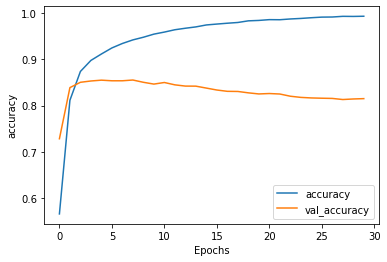

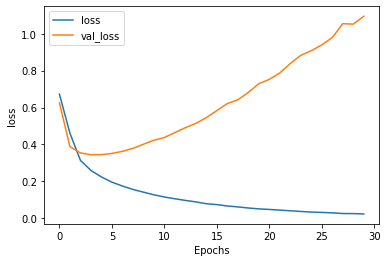

In [25]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [26]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [27]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [28]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [35]:
sentence = [
    'granny starting to fear spiders in the garden might be real',
    'the weather today is bright and sunny'
]

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, maxlen=max_length,
                      padding=padding_type,truncating= trunc_type)


In [36]:
print(model.predict(padded))

1/1 [==============================] - 0s 34ms/step
[[9.8603004e-01]
 [8.0695127e-06]]
